In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [32]:
data_path = '../../data/postprocessed/SMThroughput/'

mapping_table = {
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

../../data/postprocessed/SMThroughput/NN50PercLeNet5_1.csv
../../data/postprocessed/SMThroughput/gpuburn5min_1.csv
../../data/postprocessed/SMThroughput/NN50Percresnet18_1.csv
../../data/postprocessed/SMThroughput/NN50Percmnasnet05_1.csv
../../data/postprocessed/SMThroughput/NN50Percmobilenetv2_1.csv


## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [33]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 107848


### Apparently not

### Thus, it must be dependent only on the application complexity

In [34]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: LeNet5
Instances: 36652
--------------------------------------------------------------------
App name: MnasNet
Instances: 19516
--------------------------------------------------------------------
App name: MobileNetV2
Instances: 28050
--------------------------------------------------------------------
App name: ResNet18
Instances: 20757
--------------------------------------------------------------------
App name: GPU-burn
Instances: 2873


In [35]:
data_sheet.isna().sum()

session_id          0
duration_ms         0
location            0
metric_name         0
rollup_operation    0
range_name          0
metric_value        0
Range               0
App_name            0
progress            0
dtype: int64

### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

In [36]:
data_sheet['rollup_operation'].unique()
# It is a useless column, we can drop it
data_sheet = data_sheet.drop('rollup_operation', axis=1)

### Available data

In [37]:
location_mapping={
    'sm': 'Streaming Multiprocessor',
    'idc': 'InDexed Constant Cache'
}
data_sheet['location'].unique()

array(['idc', 'sm'], dtype=object)

In [38]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
# data_sheet.drop('location', axis=1, inplace=True)

In [40]:
metric_event_mapping= {
    'request_cycles_active': 'Number of cycles where the IDC processed requests from SM',
    'inst_executed': 'Warp instructions executed',
    'inst_executed_pipe_adu': 'Warp instructions executed by adu pipe',
    'inst_executed_pipe_cbu_pred_on_any': 'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
    'inst_executed_pipe_ipa': 'Integer and Predicate Arithmetic',
    'inst_executed_pipe_lsu': 'Warp instructions executed by Load Store Units pipe',
    'inst_executed_pipe_tex': 'Warp instructions executed by Texture pipe',
    'inst_executed_pipe_uniform': 'Warp instructions executed by uniform pipe', # Istruzioni che hanno lo stesso risultato per tutti i thread di un warp
    'inst_executed_pipe_xu': 'Warp instructions executed by uniform pipe',
    'issue_active': 'Number of cycles where an SMSP issued an instruction',
    'mio2rf_writeback_active': 'Number cycles where the MIO to register file writeback interface was active',
    'mio_inst_issued': 'Number of instructions issued from MIOC (Controller) to MIO',
    'mio_pq_read_cycles_active': 'Number cycles where MIOP PQ sent register operands to a pipeline',
    'mio_pq_write_cycles_active': 'Number of cycles where register operands from the register file were written to MIO PQ',
    'pipe_alu_cycles_active': 'Number of cycles where alu pipe was active ',
    'pipe_fp64_cycles_active': 'Number of cycles where fp64 pipe was active'
}
data_sheet['metric_name'].unique()

array(['request_cycles_active', 'inst_executed', 'inst_executed_pipe_adu',
       'inst_executed_pipe_cbu_pred_on_any', 'inst_executed_pipe_ipa',
       'inst_executed_pipe_lsu', 'inst_executed_pipe_tex',
       'inst_executed_pipe_uniform', 'inst_executed_pipe_xu',
       'issue_active', 'mio2rf_writeback_active', 'mio_inst_issued',
       'mio_pq_read_cycles_active', 'mio_pq_write_cycles_active',
       'pipe_alu_cycles_active', 'pipe_fp64_cycles_active',
       'pipe_tensor_cycles_active'], dtype=object)

In [41]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
data_sheet.drop('metric_name', axis=1, inplace=True)

In [42]:
data_sheet['HR_metric_name'].unique()

array(['Number of cycles where the IDC processed requests from SM',
       'Warp instructions executed',
       'Warp instructions executed by adu pipe',
       'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
       'Integer and Predicate Arithmetic',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by uniform pipe',
       'Number of cycles where an SMSP issued an instruction',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of instructions issued from MIOC (Controller) to MIO',
       'Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of cycles where alu pipe was active ',
       'Number of cycles where fp64 pipe was active', nan], dtype=object)

### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [43]:
data_sheet['Range'].dtypes

dtype('int64')

In [44]:
data_sheet_1 = data_sheet[data_sheet['Range']==1]

### Regardless of the application I want to see the correlation within the columns

In [45]:
df_sm = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor']
df_idc = data_sheet_1[data_sheet_1['HR_location']=='InDexed Constant Cache']

dfs = {
    'Streaming Multiprocessor': df_sm, 
    'InDexed Constant Cache': df_idc
    }

In [46]:
df_pivot_idc = df_idc.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'Streaming Multiprocessor': df_pivot_sm, 
    'InDexed Constant Cache': df_pivot_idc
    }

In [47]:
metric_full_name = data_sheet_1['HR_location'] +' '+ data_sheet_1['HR_metric_name']
metric_full_name

0         InDexed Constant Cache Number of cycles where ...
1         Streaming Multiprocessor Warp instructions exe...
2         Streaming Multiprocessor Warp instructions exe...
3         Streaming Multiprocessor Warp instructions exe...
4         Streaming Multiprocessor Integer and Predicate...
                                ...                        
107843    Streaming Multiprocessor Number cycles where M...
107844    Streaming Multiprocessor Number of cycles wher...
107845    Streaming Multiprocessor Number of cycles wher...
107846    Streaming Multiprocessor Number of cycles wher...
107847                                                  NaN
Length: 107848, dtype: object

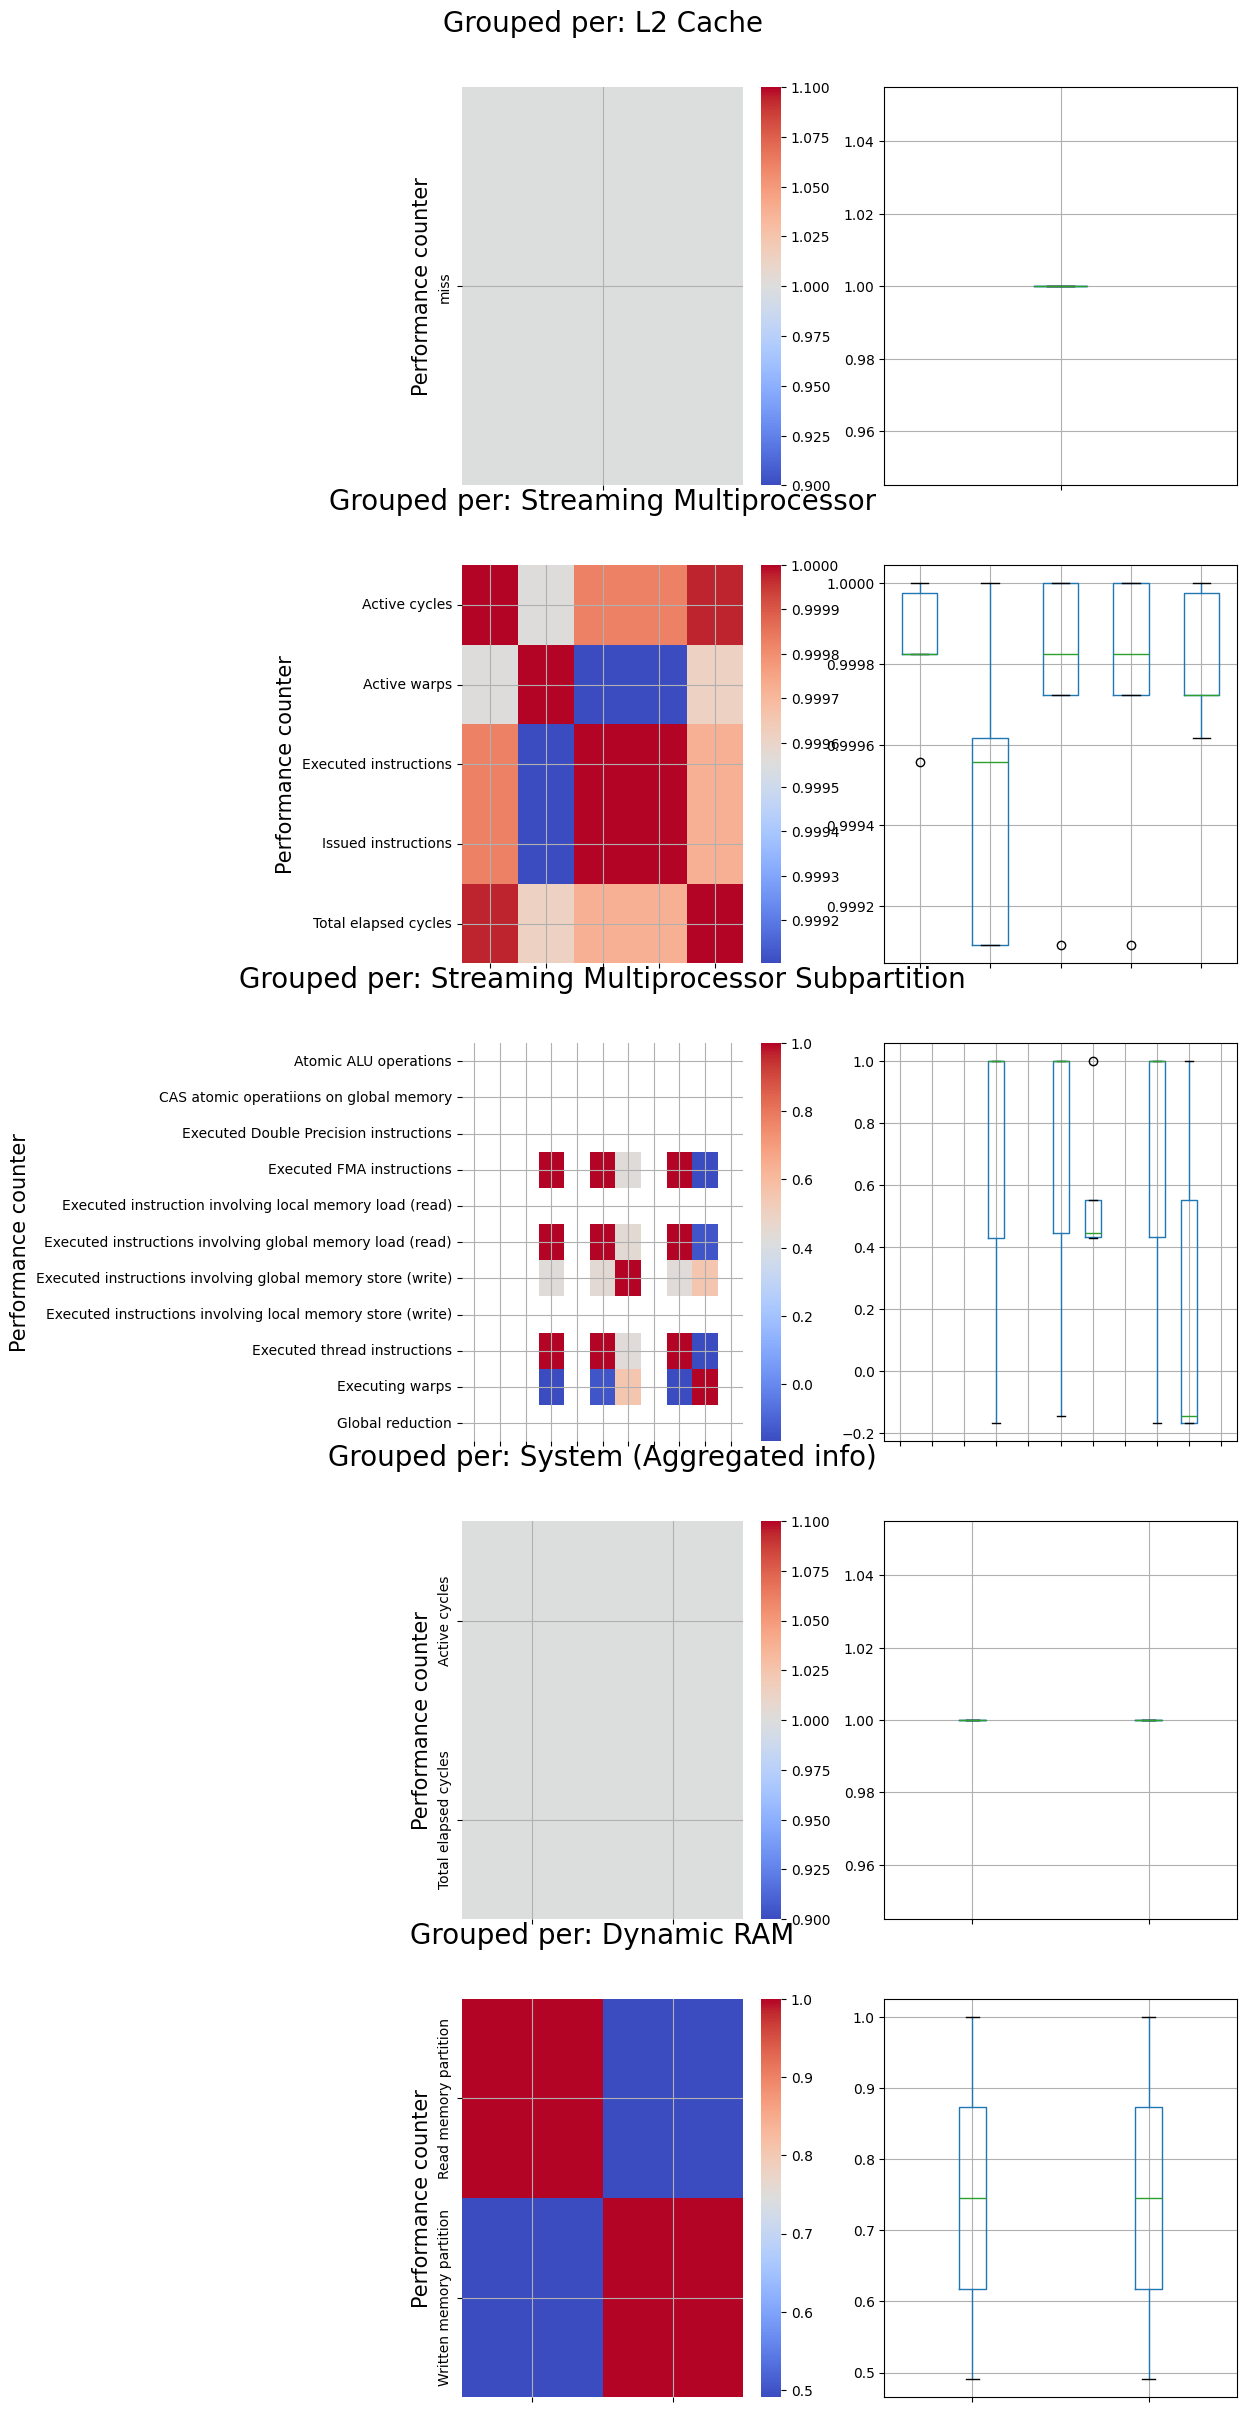

In [101]:
fig, ax = plt.subplots(5,2,figsize=(10,30))
for pivot_df_idx in range(len(list(pivot_dfs.values()))):
    HR_location = list(pivot_dfs.keys())[pivot_df_idx]
    # print(pivot_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = pivot_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = pivot_dfs[HR_location].select_dtypes(include=['float64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

### Stress evaluation

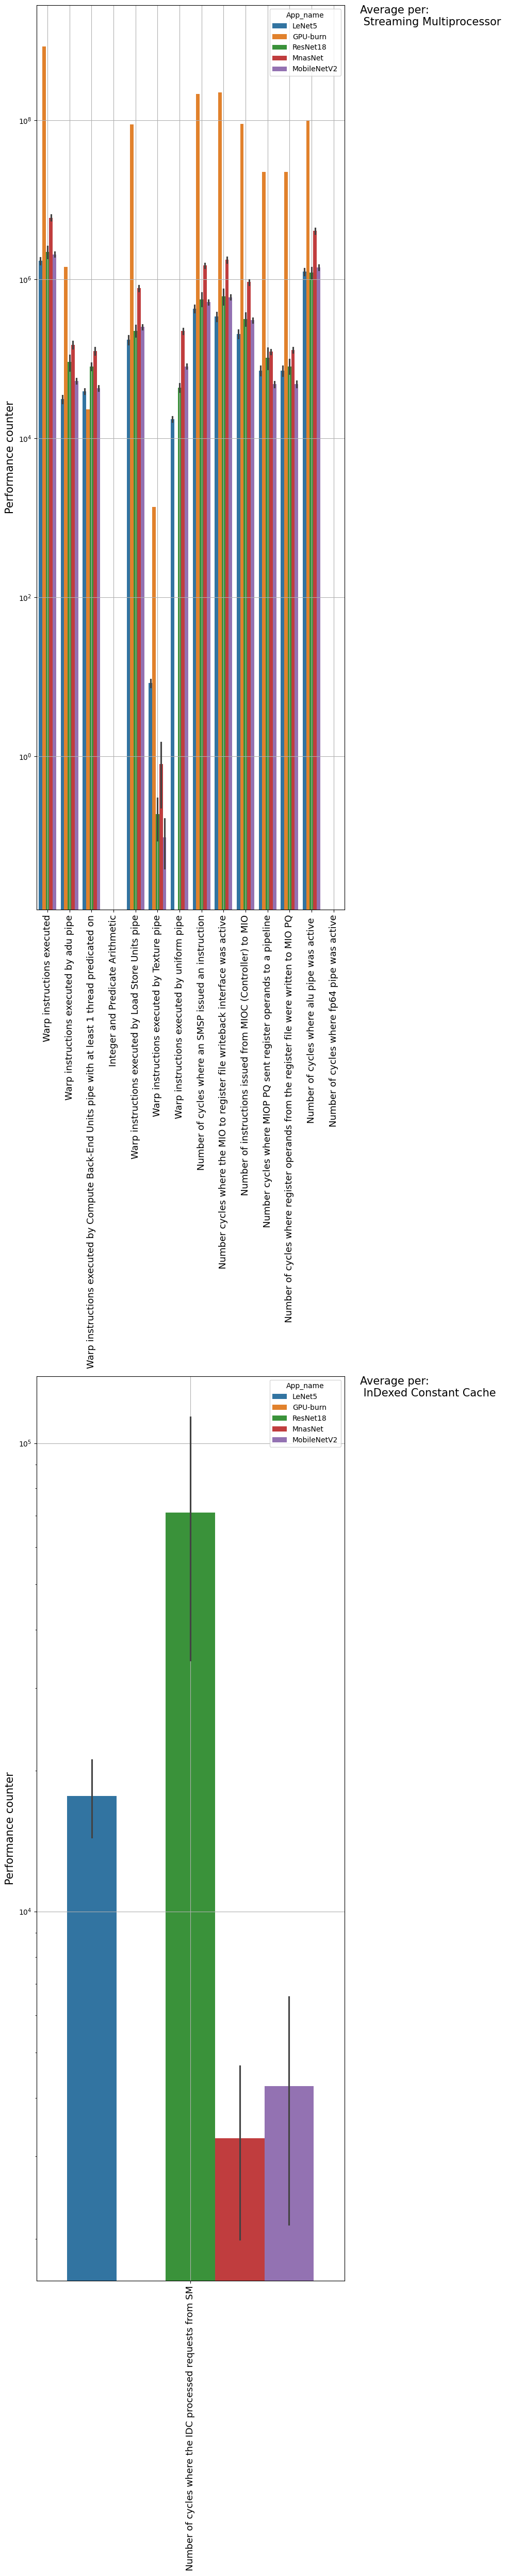

In [51]:
fig, ax = plt.subplots(2,1,figsize=(10,50))
for pivot_df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[pivot_df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metric_name', y='metric_value', hue='App_name', ax = ax[pivot_df_idx])
    # ax[pivot_df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[pivot_df_idx].text(1.05, 1.0, f'Average per: \n {HR_location}', transform=ax[pivot_df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[pivot_df_idx].grid()
    ax[pivot_df_idx].set_yscale('log')
    ax[pivot_df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[pivot_df_idx].set_xticklabels([])
    ax[pivot_df_idx].set_xlabel('')
plt.tight_layout()

/tmp/ipykernel_6429/4138551659.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_6429/4138551659.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_6429/4138551659.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_6429/4138551659.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_6

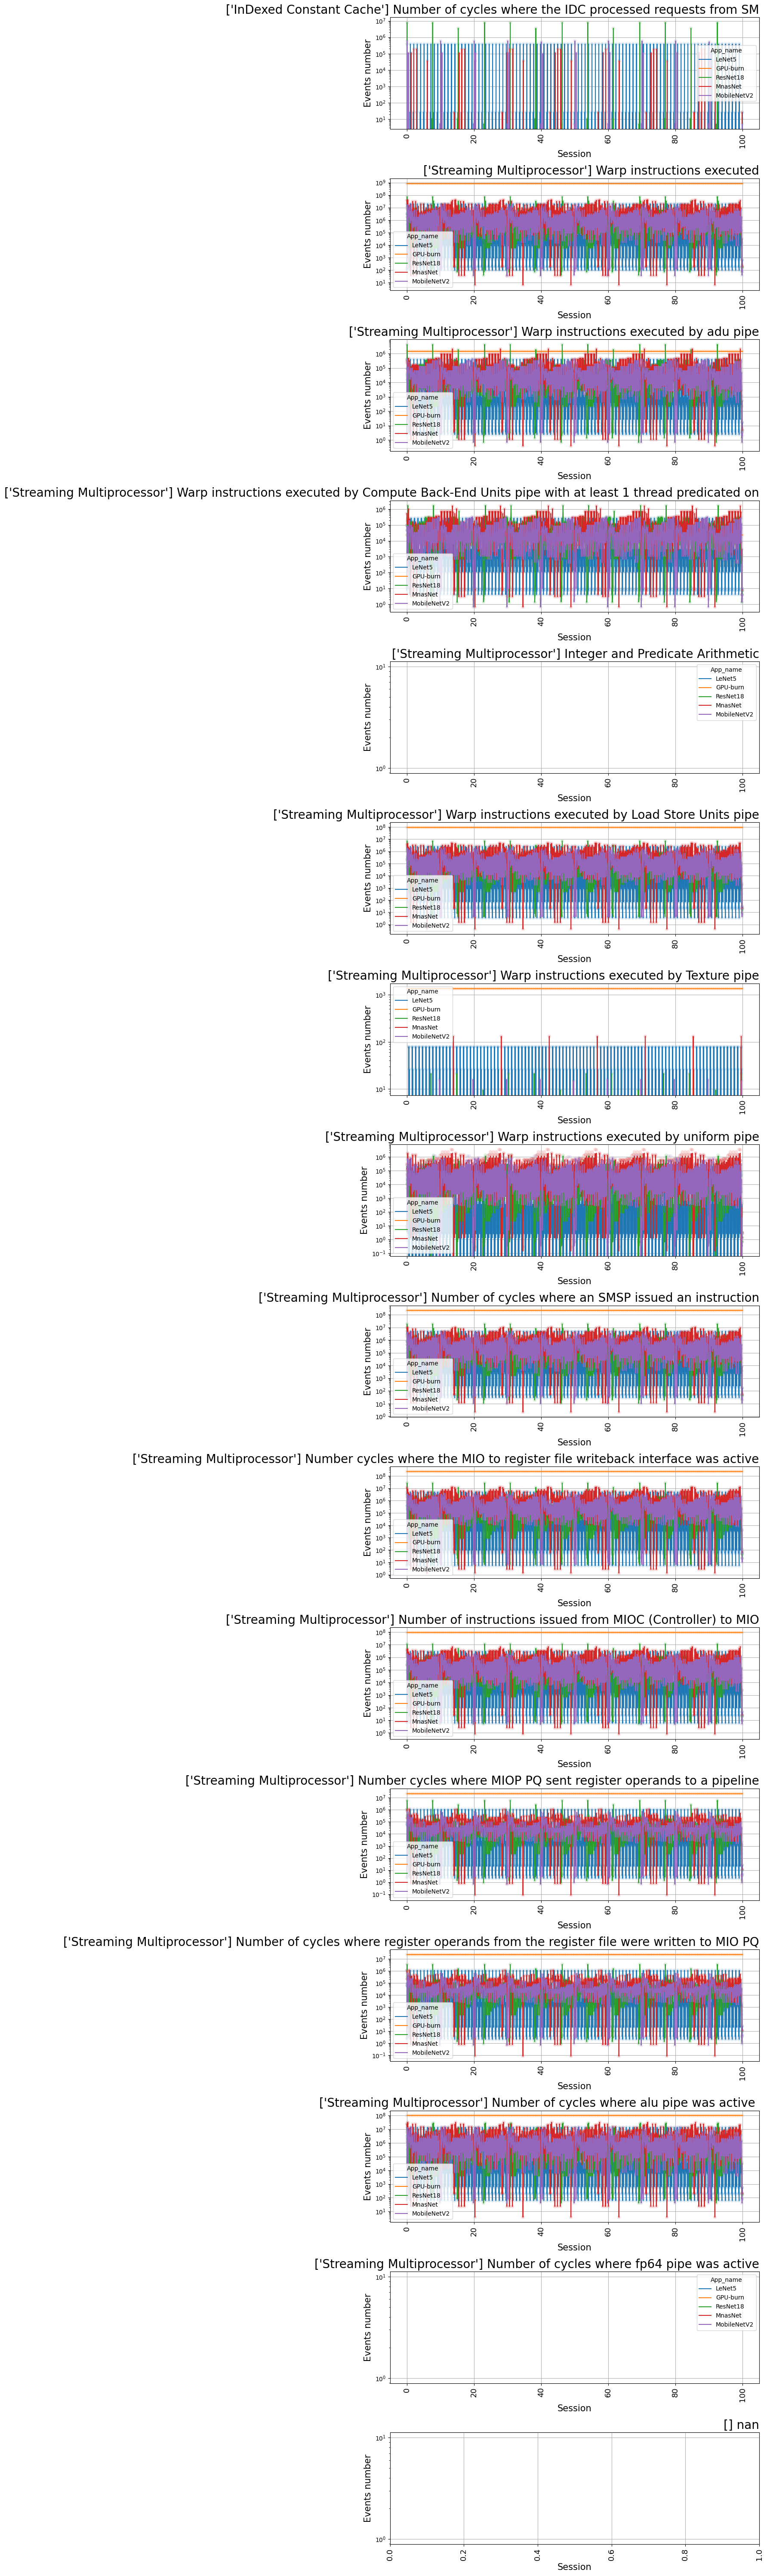

In [62]:
fig, ax = plt.subplots(16,1,figsize=(10,60))

for metric_idx in range(len(data_sheet_1['HR_metric_name'].unique())):
    metric_name = data_sheet_1['HR_metric_name'].unique()[metric_idx]
    data = data_sheet_1[data_sheet_1['HR_metric_name'] == metric_name]
    HR_location=data['HR_location'].unique()
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

### Final remarks

### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 

### Metrics description
- SM Active cycles: Per ogni SM (in media) how many times there is at least an active warp?
- SM Active warps: Per ogni SM (in media) how many warps are active?